In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train, _), (_, _) = mnist.load_data()

x_train = x_train / 127.5 - 1.0
x_train = np.expand_dims(x_train, axis=-1)

In [2]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

In [3]:
from tensorflow.keras import layers, models

def build_generator(z_dim):
    model = models.Sequential()
    model.add(layers.Dense(7*7*128, input_dim=z_dim))
    model.add(layers.Reshape((7,7,128)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='tanh'))
    return model

In [4]:
def build_critic(img_shape=(28,28,1)):
    model = models.Sequential()
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=img_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [6]:
from tensorflow.keras import optimizers
from tensorflow.keras import Model, Input

z_dim = 100
img_shape = (28,28,1)
clip_value = 0.01  

generator = build_generator(z_dim)
critic = build_critic(img_shape)

optimizer = optimizers.RMSprop(learning_rate=0.00005)

critic.compile(loss=wasserstein_loss, optimizer=optimizer)

critic.trainable = False
z = Input(shape=(z_dim,))
img = generator(z)
validity = critic(img)
wgan = Model(z, validity)
wgan.compile(loss=wasserstein_loss, optimizer=optimizer)

c:\Users\Bluepal\anaconda3\envs\python_course\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Bluepal\anaconda3\envs\python_course\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\Bluepal\anaconda3\envs\python_course\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
import matplotlib.pyplot as plt

def sample_images_wgan(epoch, n_samples=10):
    noise = np.random.normal(0, 1, (n_samples, z_dim))
    gen_imgs = generator.predict(noise, verbose=0)
    gen_imgs = 0.5 * gen_imgs + 0.5 

    fig, axs = plt.subplots(1, n_samples, figsize=(10,1))
    for i in range(n_samples):
        axs[i].imshow(gen_imgs[i,:,:,0], cmap='gray')
        axs[i].axis('off')
    plt.suptitle(f"Epoch {epoch}")
    plt.show()

In [8]:
def train_wgan(epochs, batch_size=64, n_critic=5, sample_interval=1000):
    real = -np.ones((batch_size, 1))  
    fake = np.ones((batch_size, 1))   

    for epoch in range(epochs):
        for _ in range(n_critic):
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            imgs = x_train[idx]

            noise = np.random.normal(0, 1, (batch_size, z_dim))
            gen_imgs = generator.predict(noise, verbose=0)

            d_loss_real = critic.train_on_batch(imgs, real)
            d_loss_fake = critic.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            for layer in critic.layers:
                if hasattr(layer, 'kernel'):
                    layer.kernel.assign(tf.clip_by_value(layer.kernel, -clip_value, clip_value))

        noise = np.random.normal(0, 1, (batch_size, z_dim))
        g_loss = wgan.train_on_batch(noise, real) 

        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")
            sample_images_wgan(epoch)

c:\Users\Bluepal\anaconda3\envs\python_course\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.0033] [G loss: 0.0001]


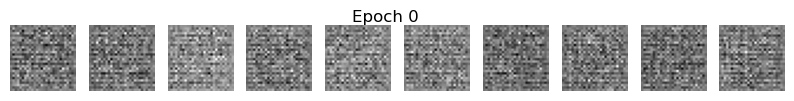

1000 [D loss: 0.0024] [G loss: -0.0042]


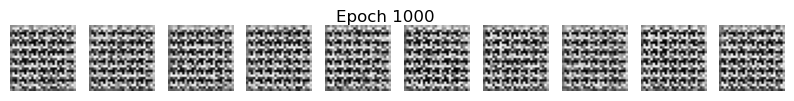

2000 [D loss: 0.0036] [G loss: -0.0064]


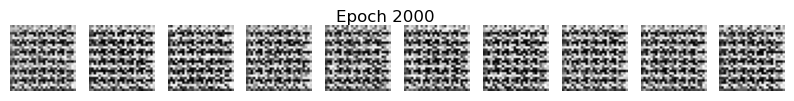

3000 [D loss: 0.0048] [G loss: -0.0087]


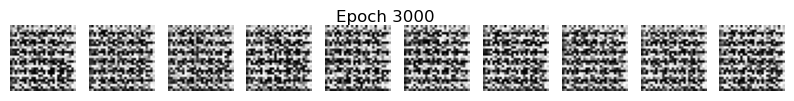

4000 [D loss: 0.0061] [G loss: -0.0113]


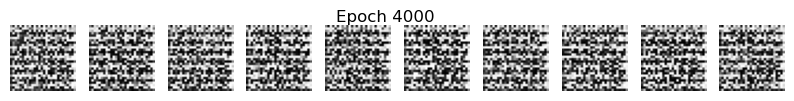

In [9]:
train_wgan(epochs=5000, batch_size=64, n_critic=5, sample_interval=1000)